# Model_3_Pose_Estimation_YOLO_NAS

# Introduction



Source: https://deci.ai/blog/pose-estimation-yolo-nas-pose/

Dataset: https://cocodataset.org/#keypoints-2017

Metric: https://github.com/Deci-AI/super-gradients/blob/master/YOLONAS-POSE.md

# Preparing the model

In [ ]:
%%capture
!pip install super-gradients
!pip install -U git+https://github.com/ytdl-org/youtube-dl.git

In [ ]:
import torch
import os
import pathlib
import re
from imutils import paths
from IPython.display import YouTubeVideo

In [ ]:
from super_gradients.training import models
from super_gradients.common.object_names import Models

yolo_nas_pose = models.get("yolo_nas_pose_s", pretrained_weights="coco_pose")

[2024-05-18 01:30:53] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


[2024-05-18 01:31:03] INFO - utils.py - NumExpr defaulting to 2 threads.
[2024-05-18 01:31:08] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco_pose dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-05-18 01:31:08] INFO - checkpoint_utils.py - License Notification: YOLO-NAS-POSE pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS-POSE.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_pose_s_coco_pose.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_po

In [ ]:
yolo_nas_pose

YoloNASPose_S(
  (backbone): NStageBackbone(
    (stem): YoloNASStem(
      (conv): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(48, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        )
        (branch_1x1): Conv2d(3, 48, kernel_size=(1, 1), stride=(2, 2))
        (post_bn): BatchNorm2d(48, eps=1e-06, momentum=0.1, affine=True, track_running_stats=True)
        (rbr_reparam): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      )
    )
    (stage1): YoloNASStage(
      (downsample): QARepVGGBlock(
        (nonlinearity): ReLU(inplace=True)
        (se): Identity()
        (branch_3x3): Sequential(
          (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=1e-06, momentum=0.1, affine=T

In [ ]:
!pip install torchinfo
from torchinfo import summary

summary(model = yolo_nas_pose,
       input_size = (1,3,640,640),
       col_names = ['input_size',
                   'output_size',
                   'num_params',
                   'trainable'],
       col_width = 20,
       row_settings = ['var_names'])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
YoloNASPose_S (YoloNASPose_S)                                     [1, 3, 640, 640]     [1, 8400, 4]         --                   True
├─NStageBackbone (backbone)                                       [1, 3, 640, 640]     [1, 96, 160, 160]    --                   True
│    └─YoloNASStem (stem)                                         [1, 3, 640, 640]     [1, 48, 320, 320]    --                   True
│    │    └─QARepVGGBlock (conv)                                  [1, 3, 640, 640]     [1, 48, 320, 320]    3,024                True
│    └─YoloNASStage (stage1)                                      [1, 48, 320, 320]    [1, 96, 160, 160]    --                   True
│    │    └─QARepVGGBlock (downsample)                            [1, 48, 320, 320]    [1, 96, 160, 160]    88,128               True
│    │    └─YoloNASCSPLayer (blocks)                     

# Using the Model

In [ ]:

def make_prediction(input_file, action, confidence=0.55):
    """
    Make a prediction using the fixed model and device, and either show or save the result.

    Args:
    - input_file (str): Path to the input file.
    - action (str): Either 'show' or 'save'.
    - confidence (float, optional): Confidence threshold. Defaults to 0.75.

    Returns:
    - None

    Raises:
    - ValueError: If the action is not 'show' or 'save'.
    """
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    if action == "show":
        yolo_nas_pose.to(device).predict(input_file, conf=confidence).show()
    elif action == "save":
        output_file = pathlib.Path(input_file).stem + "-detections" + pathlib.Path(input_file).suffix
        yolo_nas_pose.to(device).predict(input_file, conf=confidence).save(output_file)
        print(f"Prediction saved to {output_file}")
    else:
        raise ValueError("Action must be either 'show' or 'save'.")

/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
[2024-05-18 01:31:25] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


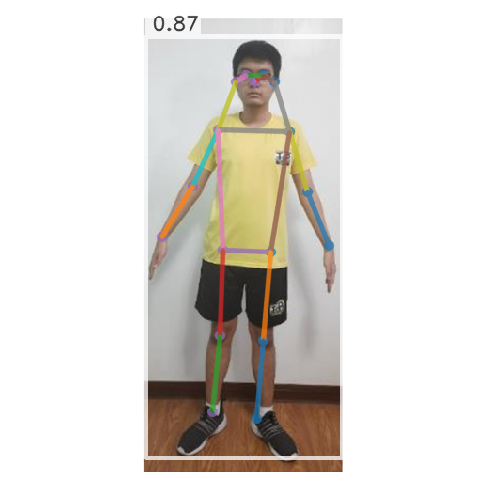

In [ ]:
url = "https://raw.githubusercontent.com/Abyza/Project_Exercise_Posture_Correction/main/Creation_of_Models/Sample_Images/paulo3.png"
make_prediction(url, "show")

In [ ]:
def process_single_image(image_prediction):
    """
    Process a single image prediction to visualize the pose estimation results on a blank background.

    Parameters:
    - image_prediction : object
        An instance containing the image and its associated pose prediction data.

    Returns:
    - np.ndarray
        An image with the pose skeleton drawn.
    """

    image = image_prediction.image
    pose_data = image_prediction.prediction

    blank_image = np.zeros_like(image)  # for a black background

    skeleton_image = PoseVisualization.draw_poses(
        image=blank_image,
        poses=pose_data.poses,
        boxes=pose_data.bboxes_xyxy,
        scores=pose_data.scores,
        is_crowd=None,
        edge_links=pose_data.edge_links,
        edge_colors=pose_data.edge_colors,
        keypoint_colors=pose_data.keypoint_colors,
        joint_thickness=2,
        box_thickness=2,
        keypoint_radius=5
    )
    return skeleton_image

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from super_gradients.training.utils.visualization.detection import draw_bbox
from super_gradients.training.utils.visualization.pose_estimation import PoseVisualization

[2024-05-18 01:31:27] INFO - pipelines.py - Fusing some of the model's layers. If this takes too much memory, you can deactivate it by setting `fuse_model=False`


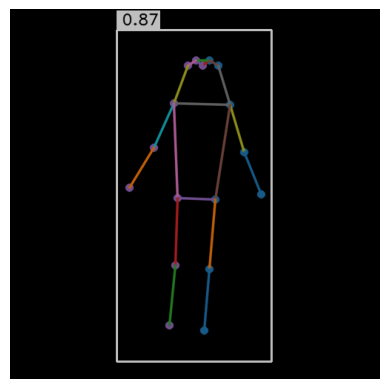

In [ ]:
jumpman = yolo_nas_pose.to('cpu').predict(url, conf=.55)

image_prediction = jumpman # Assuming you have just a single image

skeleton_image = process_single_image(image_prediction)

plt.imshow(skeleton_image)
plt.axis('off')
plt.show()

# Converting the Model

In [ ]:
yolo_nas_pose.export("model_3_post_estimation_yolo_nas.onnx", postprocessing=None, preprocessing=None)
# Print confirmation
print("Model exported to ONNX format successfully.")

In [ ]:
import onnx

# Load the ONNX model
onnx_model = onnx.load('/content/model_3_post_estimation_yolo_nas.onnx')

# Display the inputs of the model
print("Inputs:")
for input in onnx_model.graph.input:
    print(input.name, input.type)

# Display the outputs of the model
print("\nOutputs:")
for output in onnx_model.graph.output:
    print(output.name, output.type)

# Display the layers of the model
print("\nLayers:")
for node in onnx_model.graph.node:
    print(node.op_type, node.name)

Model exported to ONNX format successfully.
Inputs:
input tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 3
    }
    dim {
      dim_value: 640
    }
    dim {
      dim_value: 640
    }
  }
}


Outputs:
1393 tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 8400
    }
    dim {
      dim_value: 4
    }
  }
}

1385 tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 8400
    }
    dim {
      dim_value: 1
    }
  }
}

1402 tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 8400
    }
    dim {
      dim_value: 17
    }
    dim {
      dim_value: 2
    }
  }
}

1403 tensor_type {
  elem_type: 1
  shape {
    dim {
      dim_value: 1
    }
    dim {
      dim_value: 8400
    }
    dim {
      dim_value: 17
    }
  }
}


Layers:
Conv /model/backbone/stem/conv/rbr_reparam/Conv
Relu /model/

# Testing the Converted Model

In [ ]:
import onnx

def check_layers_and_weights(onnx_model):
    # Number of layers
    num_layers = len(onnx_model.graph.node)

    # Number of weights
    num_weights = len(onnx_model.graph.initializer)

    if num_layers > 0 and num_weights > 0:
        print("The ONNX model contains both layers and weights.")
    elif num_layers > 0:
        print("The ONNX model contains only layers (no weights).")
    elif num_weights > 0:
        print("The ONNX model contains only weights (no layers).")
    else:
        print("The ONNX model contains neither layers nor weights.")

    print("Number of layers:", num_layers)
    print("Number of weights:", num_weights)

# Load the ONNX model
onnx_model = onnx.load('/content/model_3_post_estimation_yolo_nas.onnx')

# Check layers and weights
check_layers_and_weights(onnx_model)

 /model/neck/neck2/blocks/bottlenecks/bottlenecks.0/Mul
Add /model/neck/neck2/blocks/bottlenecks/bottlenecks.0/Add
Conv /model/neck/neck2/blocks/bottlenecks/bottlenecks.1/cv1/rbr_reparam/Conv
Relu /model/neck/neck2/blocks/bottlenecks/bottlenecks.1/cv1/nonlinearity/Relu
Conv /model/neck/neck2/blocks/bottlenecks/bottlenecks.1/cv2/rbr_reparam/Conv
Relu /model/neck/neck2/blocks/bottlenecks/bottlenecks.1/cv2/nonlinearity/Relu
Mul /model/neck/neck2/blocks/bottlenecks/bottlenecks.1/Mul
Add /model/neck/neck2/blocks/bottlenecks/bottlenecks.1/Add
Conv /model/neck/neck2/blocks/conv2/conv/Conv
Relu /model/neck/neck2/blocks/conv2/act/Relu
Concat /model/neck/neck2/blocks/Concat
Conv /model/neck/neck2/blocks/conv3/conv/Conv
Relu /model/neck/neck2/blocks/conv3/act/Relu
Conv /model/neck/neck3/conv/conv/Conv
Relu /model/neck/neck3/conv/act/Relu
Concat /model/neck/neck3/Concat
Conv /model/neck/neck3/blocks/conv1/conv/Conv
Relu /model/neck/neck3/blocks/conv1/act/Relu
Conv /model/neck/neck3/blocks/bottlene

In [ ]:
import onnx
import onnxruntime as ort
import numpy as np

# Load the ONNX model
onnx_model = onnx.load('model_3_post_estimation_yolo_nas.onnx')

# Create an ONNX runtime inference session
session = ort.InferenceSession('model_3_post_estimation_yolo_nas.onnx')

# Get the input name of the model
input_name = session.get_inputs()[0].name

# Define the input shape
input_shape = (1, 3, 640, 640)

# Generate sample input data
input_data = np.random.rand(*input_shape).astype(np.float32)

# Perform inference
output = session.run(None, {input_name: input_data})

# Print the output
print(output)

The ONNX model contains both layers and weights.
Number of layers: 321
Number of weights: 263


In [ ]:
import onnx
import onnxruntime as ort
import numpy as np
import time

def inference_onnx_model(model_path, input_shape):
    # Load the ONNX model
    onnx_model = onnx.load(model_path)

    # Create an ONNX runtime inference session
    session = ort.InferenceSession(model_path)

    # Get the input name of the model
    input_name = session.get_inputs()[0].name

    # Generate sample input data
    input_data = np.random.rand(*input_shape).astype(np.float32)

    # Perform inference and measure execution time
    start_time = time.time()
    output = session.run(None, {input_name: input_data})
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    return output, execution_time

# Example usage:
model_path = 'model_3_post_estimation_yolo_nas.onnx'
input_shape = (1, 3, 640, 640)

output, execution_time = inference_onnx_model(model_path, input_shape)
print("Execution time:", execution_time, "seconds")


[array([[[-5.0993299e-01, -2.2609372e+00,  2.8446749e+01,  1.7791428e+01],
        [-1.9257401e+01, -3.4918323e+00,  5.2827629e+01,  1.9340578e+01],
        [-2.3077129e+01, -3.2237425e+00,  5.8704552e+01,  3.8870998e+01],
        ...,
        [ 4.6801392e+02,  3.9007513e+02,  6.3954724e+02,  6.4106952e+02],
        [ 4.6841589e+02,  2.0750034e+02,  6.3924951e+02,  6.4126215e+02],
        [ 4.1479495e+02,  2.7249634e+02,  6.4218762e+02,  6.3717688e+02]]],
      dtype=float32), array([[[7.1167946e-05],
        [2.5540590e-04],
        [6.4072013e-04],
        ...,
        [2.9802322e-08],
        [2.9802322e-07],
        [4.6253204e-05]]], dtype=float32), array([[[[-6.14690113e+00,  9.39239979e-01],
         [-1.39636612e+00, -4.81178856e+00],
         [ 5.73294592e+00, -6.10409737e+00],
         ...,
         [ 1.53686419e+01,  2.98952885e+01],
         [-5.13193226e+00,  3.12303219e+01],
         [ 1.54983625e+01,  3.59023285e+01]],

        [[-4.04045296e+00,  2.56976843e+00],
      

In [ ]:
import numpy as np

# Define the number of tests
num_tests = 100

# Initialize an empty list to store execution times
execution_times = []

# Run the function multiple times
for _ in range(num_tests):
    output, execution_time = inference_onnx_model(model_path, input_shape)
    execution_times.append(execution_time)

# Calculate the average execution time
average_execution_time = np.mean(execution_times)

print("Average execution time over", num_tests, "tests:", average_execution_time, "seconds")

Execution time: 0.7227723598480225 seconds


In [ ]:
print("Average execution time over", num_tests, "tests:", average_execution_time, "seconds")

In [ ]:
output[0].shape

(1, 8400, 4)

# Summary

You Only Look Once - Neural Architecture Search


| YOLO-NAS_s                  | Model #3         |
|-----------------------------|------------------|
| mAP (Mean Average Precision)| 88.8             |
| Time on Laptop CPU          | 0.0801 sec       |
| Time on Google Collab CPU   | 0.7228 sec       |
| Number of layers            | 321              |
| Number of weights           | 263              |
| Onnx Model Size             | 60.2 mb          |
| Input shape                 | (1, 3, 640, 640) |
| Output shape                | (1, 8400, 4)     |
| # of Keypoints              | 17               |




Google Collab Link:

https://colab.research.google.com/drive/1ms5wJQATYd-GObnj42PwZOHJIkAMX0UU?usp=sharing